In [4]:
!python augmentation_colab.py
!python config.py
!python np.py


In [2]:
from pathlib import Path
import augmentation_colab
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import Compose
from PIL import Image
from np import *  # import numpy as np
import cv2
import torch
import random

# __getitem__でiterを明示せずにデータ収集できるか
class image_feature(Dataset):
    IMG_EXTENSIONS = [".jpg", ".jpeg", ".png", ".bmp"]

    def __init__(self, img_dir,cuda_enabled,augment,img_w,img_h):
        # 画像ファイルのパス一覧を取得する。
        img_dir = Path(img_dir)
        # img_dirから1つ下のディレクトリをワイルドカードで読みだすので、イヌ、ネコのフォルダー名0/1を別々に処理する必要がない
        dir_list = img_dir.glob('*/*')
        self.img_paths = [ p for p in dir_list if p.suffix in image_feature.IMG_EXTENSIONS]

        path = self.img_paths
        self.labels =[]
        self.images =[]
        #composeは以下参照　画像処理を全てまとめて連続処理するためのパイプライン。この中でaugmentationもできるらしい
        #https://pytorch.org/vision/main/generated/torchvision.transforms.v2.Compose.html
        #https://cgpipeliner.info/2022/04/03/torchvision-transform-for-pilimage/
        #https://pystyle.info/pytorch-list-of-transforms/#outline__4_1

        # interpolationはresizeにともなう画像ノイズを補完するもの
        # https://qiita.com/sinpcw/items/fd432374ba31b44af864

        self.transform=Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
        #self.transform=Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

        def build_dataset(label, img):
            img=Image.fromarray(img)
            img = self.transform(img)

            self.labels.append(label)
            self.images.append(img)



        for i in range(len(path)):
            img = Image.open(path[i])
            img = np.asarray(img)
            #img=cv2.imread(str(path[i]))
            #img = cv2.resize(img, dsize=(img_w,img_h))
            label = int(str(path[i]).split("/")[-2])# ディレクトリをパス\をセパレータにしてリスト型にしたうえで、後ろから2つ目、つまりイヌ、ネコ画像の親フォルダ0,1の文字列を読んでいる
            build_dataset(label,img)
            if augment ==0:
                continue
            aug = augmentation_colab.aug(img,cuda_enabled)
            img_h_flip = aug.horizontal_flip()
            build_dataset(label,img_h_flip)
            for j in range(1):
                shear_range =0.2
                img_affine = aug.affine(shear_range)
                build_dataset(label,img_affine)
                shift_ratio = 0.3
                img_shift = aug.horizontal_shift(shift_ratio)
                build_dataset(label,img_shift)
                crop_rate=0.7
                img_crops = aug.random_crop(crop_rate)
                build_dataset(label,img_crops)

        self.labels=torch.tensor(self.labels, dtype=torch.long)

    def __getitem__(self, index):

        img = self.images[index]
        label = self.labels[index]


        return img, label

    def __len__(self):
        """ディレクトリ内の画像ファイルの数を返す。
        """
        return len(self.images)
'''
if __name__ == '__main__':
    cuda_enabled=cv2.cuda.getCudaEnabledDeviceCount()
    print('Enabled CUDA devices:',cuda_enabled) # 1
    dataset = image_feature("C:/Users/uhoku/Dropbox/Python/bag_of_visual_words/catdog/img/",cuda_enabled,0)
    print(len(dataset))
    print(dataset[0])

    im = ToNDarray(dataset[0][0])
    plt.imshow(im)
'''

'\nif __name__ == \'__main__\':\n    cuda_enabled=cv2.cuda.getCudaEnabledDeviceCount()\n    print(\'Enabled CUDA devices:\',cuda_enabled) # 1\n    dataset = image_feature("C:/Users/uhoku/Dropbox/Python/bag_of_visual_words/catdog/img/",cuda_enabled,0)\n    print(len(dataset))\n    print(dataset[0])\n\n    im = ToNDarray(dataset[0][0])\n    plt.imshow(im)\n'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
device: cuda
Epoch: 1, loss:  0.0681
Epoch: 1, val_loss:  0.0667
Epoch: 2, loss:  0.0616
Epoch: 2, val_loss:  0.0658
Epoch: 3, loss:  0.0595
Epoch: 3, val_loss:  0.0643
Epoch: 4, loss:  0.0579
Epoch: 4, val_loss:  0.0639
Epoch: 5, loss:  0.0567
Epoch: 5, val_loss:  0.0634
Epoch: 6, loss:  0.0555
Epoch: 6, val_loss:  0.0626
Epoch: 7, loss:  0.0547
Epoch: 7, val_loss:  0.0618
Epoch: 8, loss:  0.0539
Epoch: 8, val_loss:  0.0614
Epoch: 9, loss:  0.0531
Epoch: 9, val_loss:  0.0608
Epoch: 10, loss:  0.0524
Epoch: 10, val_loss:  0.0607
Epoch: 11, loss:  0.0519
Epoch: 11, val_loss:  0.0608
Epoch: 12, loss:  0.0512
Epoch: 12, val_loss:  0.0605
Epoch: 13, loss:  0.0507
Epoch: 13, val_loss:  0.0602
Epoch: 14, loss:  0.0502
Epoch: 14, val_loss:  0.0598
Epoch: 15, loss:  0.0498
Epoch: 15, val_loss:  0.0597
Epoch: 16, loss:  0.0494
Epoch: 16, val_loss:  0.0598
Epoch: 17, l

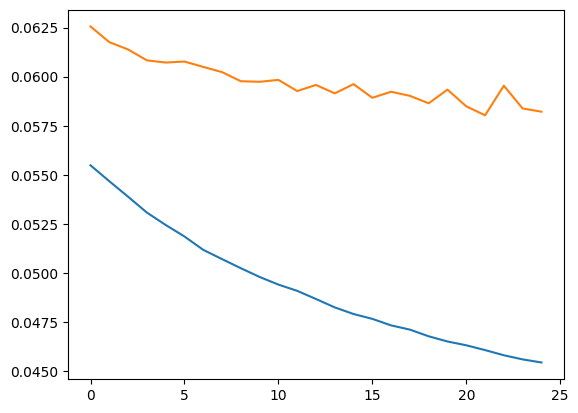

Accuracy: 73.67256637168141% (333/452)


In [6]:
import os
import glob
import cv2
import torch
import torchvision
import torch.nn.functional as f
#from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
#from create_dataset import img2tensor
#from learning import cnn_train, cnn_test,output_graph
from model import MyNet # このあと自分で定義するmodel.pyからのネットワーククラス
#from get_image_tensor import image_feature
from google.colab import drive
import torch.nn as nn
from np import *  # import numpy as np

# https://qiita.com/harutine/items/972cc5ff7868d6dec27b#3-pytorch%E3%81%A7%E3%81%AEcnn%E5%AE%9F%E8%A3%85

drive.mount('/content/drive')

# 計算環境が、CUDA(GPU)か、CPUか
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ' + device)

# 学習・テスト結果の保存用辞書
history_train = {
    'train_loss': [],   # 損失関数の値
    'train_acc': [],    # 正解率
}

history_test = {
    'test_loss': [],    # 損失関数の値
    'test_acc': [],     # 正解率
}
img_w=128
img_h=128
# ネットワークを構築（ : torch.nn.Module は型アノテーション）
# 変数netに構築するMyNet()は「ネットワークの実装」で定義します
model : torch.nn.Module = MyNet(img_w,img_h)
model = model.to(device) # GPUあるいはCPUに合わせて再構成

# データローダー・データ数を取得
#（load_dataは「学習データ・テストデータのロードの実装（データローダー）」の章で定義します）
#train_dir = args.trainDir # 学習用画像があるディレクトリパス
#test_dir = args.testDir   # テスト用画像があるディレクトリパス

path = '/content/drive/My Drive/catdog/img/'
#catdog_dir = 'C:/Users/uhoku/Dropbox/Python/CNN/catdog/img/'


no_of_augment =2
dataset = image_feature(path,device,no_of_augment,img_w,img_h)



# 画像データ・正解ラベルのペアをデータにセットする
#TensorDatasetはtensor をデータセット型に変換するメソッド。1上記のimage_featureでは、これに代えてclass image_feature(Dataset):でカスタマイズしたdataset作成メソッドを使う
# このようにカスタマイズしたデータセットを使いたい場合は、TensorDatasetのかわりにDatasetメソッドを継承して使う
#dataset = torch.utils.data.TensorDataset(data_tensor, label_tensor)

train_data_size = int(len(dataset) * 0.8)
test_data_size = len(dataset)-train_data_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_data_size, test_data_size])
train_length=len(train_data)
val_length = len(val_data)

# セットしたデータをバッチサイズごとの配列に入れる。
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)



optimizer=torch.optim.Adagrad(model.parameters(), lr=0.0001, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,500], gamma=0.5)
criterion = nn.CrossEntropyLoss()
history = {"train_loss": [], "val_loss": [], "labels":[],"train_loss_byBatch":[]}
num_epochs=30
Y_train = []
pred_train =[]
min_loss=10000000000
predicts=[]
trues = []
n_epoch=0
for epoch in range(num_epochs):
  model.train()# nn.moduleを継承したクラスからオブジェクトを生成した場合、訓練と予測はコードをそれぞれ記述
             # する必要はなく　train(), eval()　で自動的にに切り替わる

  train_loss_acc=0
  for i, (x, labels) in enumerate(train_loader):

    #x=torch.t(x)
    x = x.to(device)
    labels = labels.to(device)
    output = model(x)
    # 分類問題の場合output は、行方向がバッチサイズ、列方向がクラス数であるような2次元配列
    # これに対して、labelsは、バッチサイズ分の1次元配列。分類問題でのニューラルネットワークの
    # 教師ラベルレイヤは、one hot なので、本来はoutputと同じクラス数分の次元数をもつはずだか
    # これは、nn.CrossEntropyLoss()のなかで自動的にデータ形式の変換をやっている模様
    # また、criterion での損失計算結果 loss は、バッチサイズ分足し合わせたスカラーになる。
    loss = criterion(output, labels)
    history["train_loss_byBatch"].append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss_acc+=loss
    if num_epochs-1 == epoch:
      Y_train+=labels.view(1,-1).cpu().detach().numpy().copy().tolist()
      pred_train+=output.view(1,-1).cpu().detach().numpy().copy().tolist()

  train_loss=train_loss_acc/train_length

  #if 損失が閾値以上ならepochをリセット
  print(f'Epoch: {epoch+1}, loss: {train_loss: 0.4f}')
  history["train_loss"].append(train_loss)

  if train_loss<min_loss:
        min_loss=train_loss
        torch.save(model, 'best_model.pth')


  scheduler.step()

  correct = 0
  model.eval()

  val_loss_acc=0
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):

      x = x.to(device)
      labels = labels.to(device)

      output = model(x)
      loss = criterion(output,labels)
      val_loss_acc+=loss

      if num_epochs-1 == epoch:
        pred = output.argmax(1)
        predicts+=pred.cpu().detach().numpy().copy().tolist()
        trues+=labels.cpu().detach().numpy().copy().tolist()
        # 正解数をカウント
        correct += pred.eq(labels.view_as(pred)).sum().item()
  val_loss = val_loss_acc/val_length
  print(f'Epoch: {epoch+1}, val_loss: {val_loss : 0.4f}')
  history["val_loss"].append(val_loss)
  '''
  if n_epoch >10:
      break
  else:
    if val_loss < train_loss :
      n_epoch +=1
    else:
      n_epoch =0
  '''

train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.cpu().detach().numpy().copy()
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.cpu().detach().numpy().copy()
plt.plot(train_loss_np[5:])
plt.plot(val_loss_np[5:])
plt.show()


'''
train_loss_batch = torch.stack(history["train_loss_byBatch"])
train_loss_batchnp = train_loss_batch.detach().numpy().copy()

plt.plot(train_loss_batchnp)
plt.show()
'''



print(f"Accuracy: {100*correct/len(val_data)}% ({correct}/{len(val_data)})")